In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [212]:
df = pd.read_csv('SAPio_DataScience_Challenge[2].csv')

For this analysis, I am tasked to find what makes wine 'good'. I will split the dataset into two pieces, one for red wine and one for white wine. The reasoning for this is that inherently red and white wine are very different in terms of taste and composition, so factors that make a good red wine may not be the same as that of white wine

In [213]:
red = df[df['type'] == 'red']

In [214]:
white = df[df['type'] == 'white']

In [215]:
red = red.drop(['type'], axis=1)

In [216]:
white = white.drop(['type'], axis=1)

In [217]:
red_cols = red.columns

In [218]:
white_cols = white.columns

### EDA

In [219]:
red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599 entries, 0 to 1598
Data columns (total 14 columns):
fixed acidity           1599 non-null float64
volatile acidity        1520 non-null float64
citric acid             1599 non-null float64
astringency rating      1522 non-null float64
residual sugar          1010 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1578 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
vintage                 1582 non-null float64
quality                 1599 non-null int64
dtypes: float64(13), int64(1)
memory usage: 187.4 KB


### Missing Data Imputation

In [220]:
def print_missing(df):
    for x in df.columns:
        mis = len(df[df[x].isnull()])
        if mis > 0:
            print(x + ' -> missing data for ' + str(mis)) + ' rows'

In [221]:
print("Missing values for red wine:")
print("-"*50)
print_missing(red)
print("\n")

print("Missing values for white wine:")
print("-"*50)
print_missing(white)

Missing values for red wine:
--------------------------------------------------
volatile acidity -> missing data for 79 rows
astringency rating -> missing data for 77 rows
residual sugar -> missing data for 589 rows
pH -> missing data for 21 rows
vintage -> missing data for 17 rows


Missing values for white wine:
--------------------------------------------------
volatile acidity -> missing data for 220 rows
astringency rating -> missing data for 255 rows
residual sugar -> missing data for 1775 rows
pH -> missing data for 41 rows
vintage -> missing data for 52 rows


For columns with missing data, I decided to use KNN imputation to fill the missing data when variable is continuous, and simply impute mode when variable is categorical

In [222]:
def impute_mode(df):
    for col in ['vintage', 'quality']:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

In [223]:
red = impute_mode(red)

In [224]:
red = KNN(k=3).complete(red)
red = pd.DataFrame(red, columns=red_cols)
red.head(10)

Imputing row 1/1599 with 0 missing, elapsed time: 0.656
Imputing row 101/1599 with 0 missing, elapsed time: 0.660
Imputing row 201/1599 with 1 missing, elapsed time: 0.666
Imputing row 301/1599 with 0 missing, elapsed time: 0.672
Imputing row 401/1599 with 1 missing, elapsed time: 0.674
Imputing row 501/1599 with 1 missing, elapsed time: 0.677
Imputing row 601/1599 with 0 missing, elapsed time: 0.679
Imputing row 701/1599 with 1 missing, elapsed time: 0.681
Imputing row 801/1599 with 0 missing, elapsed time: 0.683
Imputing row 901/1599 with 0 missing, elapsed time: 0.685
Imputing row 1001/1599 with 0 missing, elapsed time: 0.688
Imputing row 1101/1599 with 1 missing, elapsed time: 0.691
Imputing row 1201/1599 with 0 missing, elapsed time: 0.693
Imputing row 1301/1599 with 0 missing, elapsed time: 0.696
Imputing row 1401/1599 with 0 missing, elapsed time: 0.699
Imputing row 1501/1599 with 2 missing, elapsed time: 0.702


,fixed acidity,volatile acidity,citric acid,astringency rating,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,vintage,quality
0,7.4,0.700000,0.00,0.81,1.900000,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2001.0,5.0
1,7.8,0.446896,0.00,0.86,2.600000,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2003.0,5.0
2,7.8,0.760000,0.04,0.85,2.300000,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2006.0,5.0
3,11.2,0.280000,0.56,1.14,1.843822,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2003.0,6.0
4,7.4,0.700000,0.00,0.81,2.255588,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2004.0,5.0
5,7.4,0.660000,0.00,0.80,1.800000,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,2004.0,5.0
6,7.9,0.600000,0.06,0.85,1.600000,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,2003.0,5.0
7,7.3,0.650000,0.00,0.79,1.200000,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,2007.0,7.0
8,7.8,0.580000,0.02,0.83,2.000000,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,2007.0,7.0
9,7.5,0.500000,0.36,0.80,6.100000,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,2005.0,5.0


In [225]:
white = impute_mode(white)

In [226]:
white = KNN(k=3).complete(white)
white = pd.DataFrame(white, columns=white_cols)
white.head(10)

Imputing row 1/4898 with 1 missing, elapsed time: 5.006
Imputing row 101/4898 with 1 missing, elapsed time: 5.009
Imputing row 201/4898 with 0 missing, elapsed time: 5.012
Imputing row 301/4898 with 0 missing, elapsed time: 5.015
Imputing row 401/4898 with 1 missing, elapsed time: 5.017
Imputing row 501/4898 with 1 missing, elapsed time: 5.020
Imputing row 601/4898 with 1 missing, elapsed time: 5.022
Imputing row 701/4898 with 1 missing, elapsed time: 5.025
Imputing row 801/4898 with 0 missing, elapsed time: 5.028
Imputing row 901/4898 with 1 missing, elapsed time: 5.031
Imputing row 1001/4898 with 1 missing, elapsed time: 5.034
Imputing row 1101/4898 with 1 missing, elapsed time: 5.036
Imputing row 1201/4898 with 0 missing, elapsed time: 5.038
Imputing row 1301/4898 with 1 missing, elapsed time: 5.041
Imputing row 1401/4898 with 2 missing, elapsed time: 5.044
Imputing row 1501/4898 with 1 missing, elapsed time: 5.046
Imputing row 1601/4898 with 0 missing, elapsed time: 5.049
Imputing 

,fixed acidity,volatile acidity,citric acid,astringency rating,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,vintage,quality
0,7.0,0.27,0.36,0.72,16.655218,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2004.0,6.0
1,6.3,0.30,0.34,0.66,4.422665,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2004.0,6.0
2,8.1,0.28,0.40,0.83,6.900000,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2006.0,6.0
3,7.2,0.23,0.32,0.74,6.267920,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2004.0,6.0
4,7.2,0.23,0.32,0.74,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2007.0,6.0
5,8.1,0.28,0.40,0.83,6.900000,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2003.0,6.0
6,6.2,0.32,0.16,0.65,7.000000,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,2004.0,6.0
7,7.0,0.27,0.36,0.72,11.869705,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2006.0,6.0
8,6.3,0.30,0.34,0.66,1.600000,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2008.0,6.0
9,8.1,0.22,0.43,0.83,1.500000,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,2004.0,6.0


In [227]:
def plot_hist(df, cols, color):
    fig = plt.figure(figsize=(18,12))
    for i, col in enumerate(cols):
        ax=fig.add_subplot(5,3,i+1)
        df[col].hist(bins=15,ax=ax, color=color)
        ax.set_title(col)
    fig.tight_layout()
    plt.show()

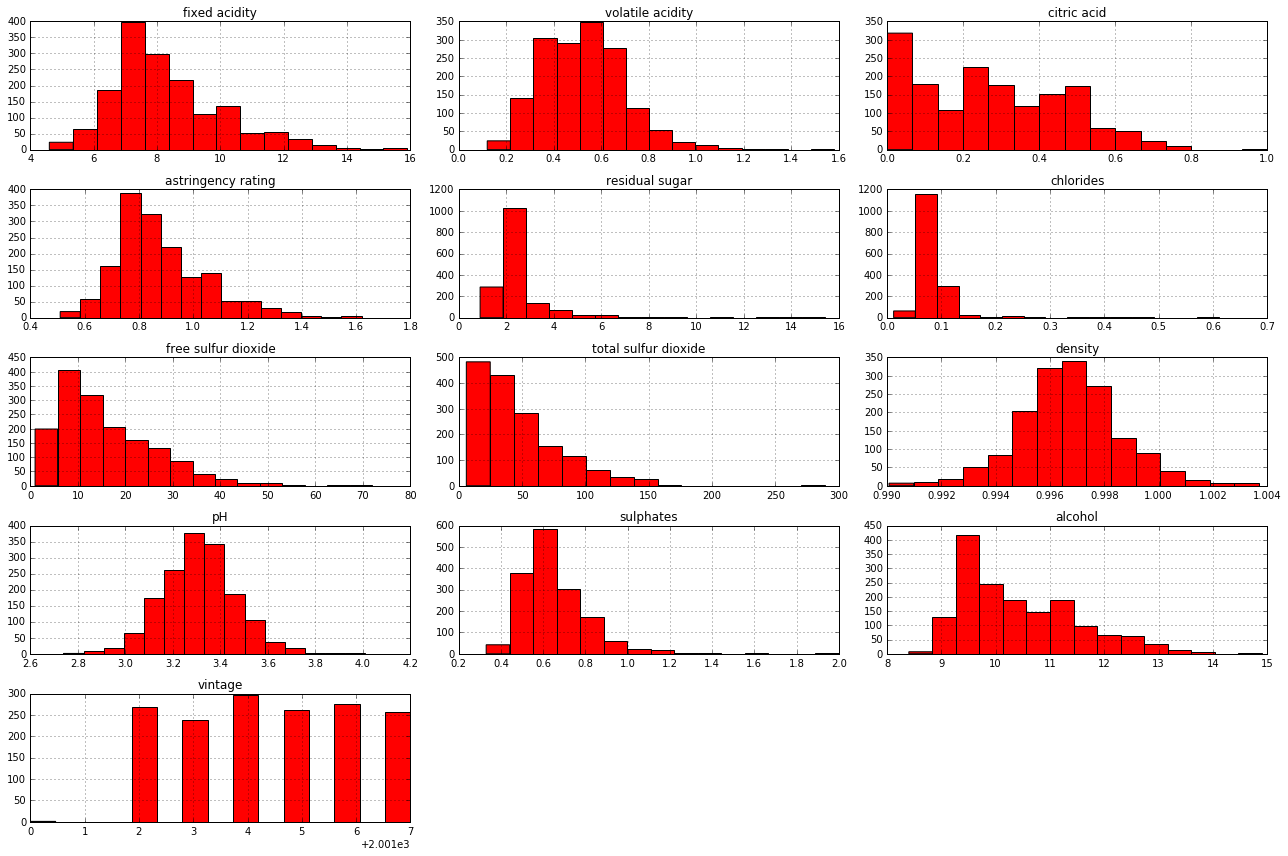

In [228]:
plot_hist(red, red.columns[:-1], 'r')

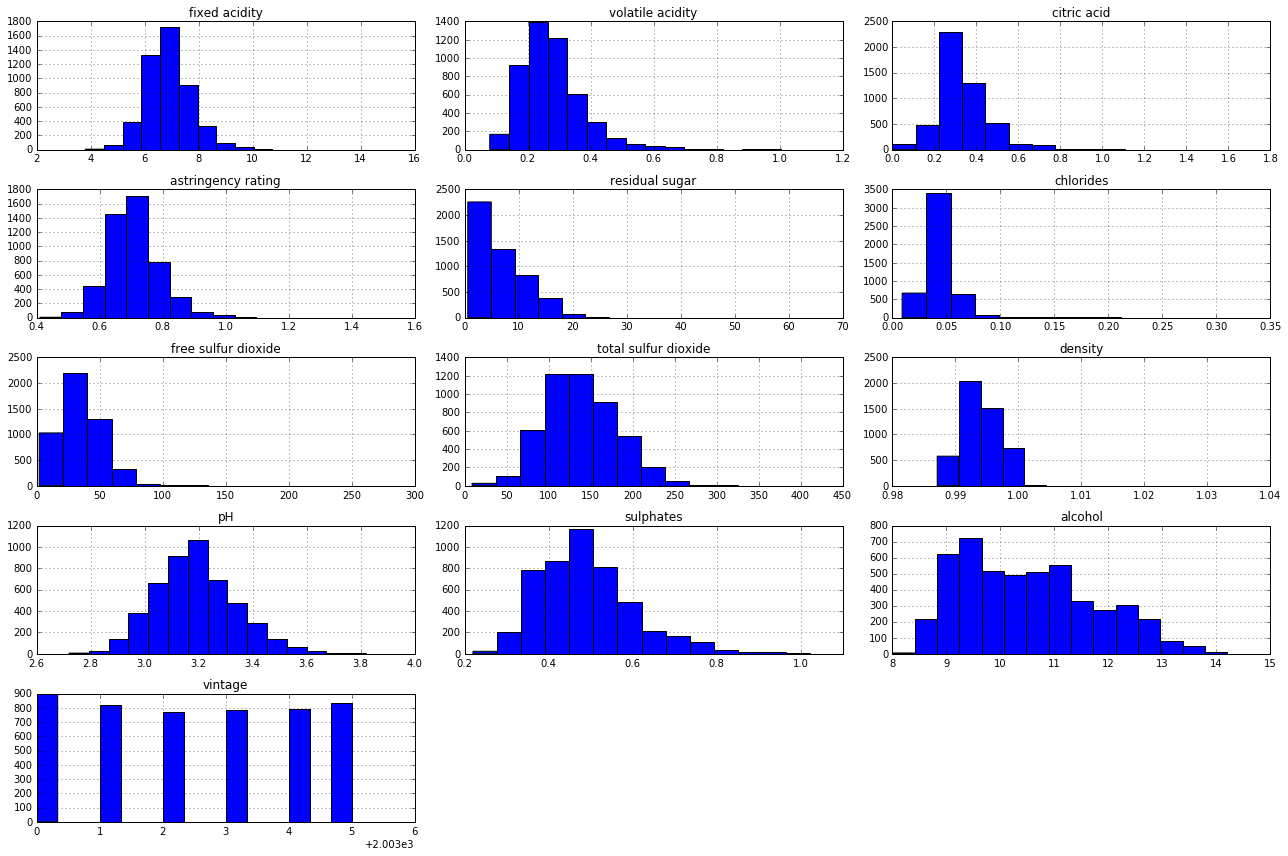

In [229]:
plot_hist(white, white.columns[:-1], 'b')

Looking at the univariate histograms above, it confirms my decision to split red and white wine is correct. You can see that the distributions are quite different between the two types of wines. Even if the shape is similar for some features, the scale is not

In [230]:
red.describe()

,fixed acidity,volatile acidity,citric acid,astringency rating,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,vintage,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.526491,0.270976,0.880226,2.557202,0.087467,15.874922,46.467792,0.996747,3.310802,0.658149,10.422983,2005.502814,5.636023
std,1.741096,0.175523,0.194801,0.169598,1.317780,0.047065,10.460157,32.895324,0.001887,0.153746,0.169507,1.065668,1.698438,0.807569
min,4.600000,0.120000,0.000000,0.510000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,2001.000000,3.000000
25%,7.100000,0.392500,0.090000,0.760000,1.980138,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,2004.000000,5.000000
50%,7.900000,0.520000,0.260000,0.840000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,2005.000000,6.000000
75%,9.200000,0.635000,0.420000,0.970000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,2007.000000,6.000000
max,15.900000,1.580000,1.000000,1.620000,15.400000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,2008.000000,8.000000


In [231]:
white.describe()

,fixed acidity,volatile acidity,citric acid,astringency rating,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,vintage,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.277879,0.334192,0.708710,6.497551,0.045772,35.308085,138.360657,0.994027,3.188307,0.489847,10.514267,2005.464067,5.877909
std,0.843868,0.098903,0.121020,0.083797,4.799632,0.021848,17.007137,42.498065,0.002991,0.150651,0.114126,1.230621,1.739062,0.885639
min,3.800000,0.080000,0.000000,0.410000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,2003.000000,3.000000
25%,6.300000,0.210000,0.270000,0.650000,2.189468,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,2004.000000,5.000000
50%,6.800000,0.260000,0.320000,0.700000,5.551926,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,2005.000000,6.000000
75%,7.300000,0.320000,0.390000,0.750000,9.700000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,2007.000000,6.000000
max,14.200000,1.005000,1.660000,1.440000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,2008.000000,9.000000


All values have been properly imputed

### Dealing with multicollinearity

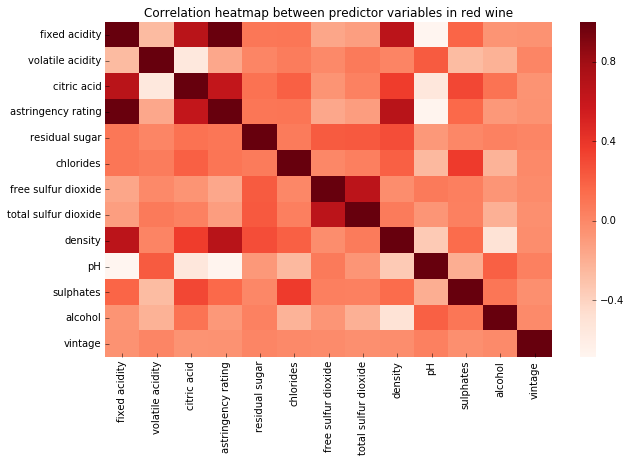

In [232]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(red.iloc[:,:-1].corr(), xticklabels=red.corr().columns[:-1], yticklabels=red.corr().columns[:-1], cmap="Reds")
ax.set_title('Correlation heatmap between predictor variables in red wine')

In [233]:
print('Highly correlated variables for red wine:' +"\n" + "-"*50)
print('fixed acidity & astringency rating: ' + str(round(red['fixed acidity'].corr(red['astringency rating']),4)))
print('fixed acidity & citric acid: ' + str(round(red['fixed acidity'].corr(red['citric acid']),4)))
print('fixed acidity & density: ' + str(round(red['fixed acidity'].corr(red['density']),4)))
print('free sulfur dioxide & total sulfur dioxide: ' + str(round(red['free sulfur dioxide'].corr(red['total sulfur dioxide']),4)))

Highly correlated variables for red wine:
--------------------------------------------------
fixed acidity & astringency rating: 0.9912
fixed acidity & citric acid: 0.6717
fixed acidity & density: 0.668
free sulfur dioxide & total sulfur dioxide: 0.6677


You can see that the features fixed acidity and astrigency rating have an extremely high correlation (0.9912), they are highly collinear and therefore it is best to remove one of the two features. I will choose to remove astrigency rating since it had some missing data before data processing. Other correlations are quite high, but I decided not to drop these variables for analysis

In [234]:
red = red.drop('astringency rating', axis = 1)

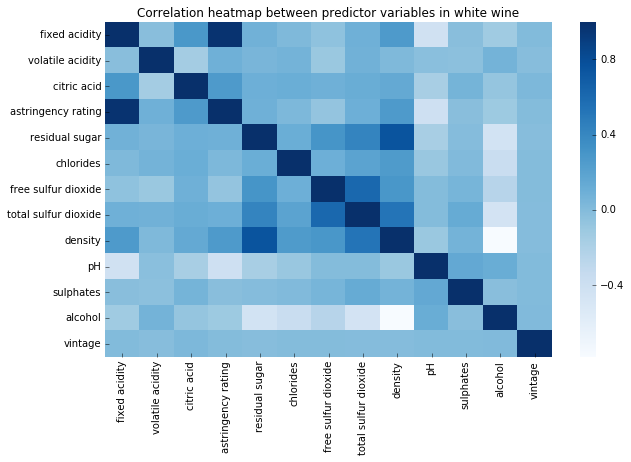

In [235]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(white.iloc[:,:-1].corr(), xticklabels=white.corr().columns[:-1], yticklabels=white.corr().columns[:-1], cmap="Blues")
ax.set_title('Correlation heatmap between predictor variables in white wine')

In [236]:
print('Highly correlated variables for white wine:' +"\n" + "-"*50)
print('fixed acidity & astringency rating: ' + str(round(white['fixed acidity'].corr(white['astringency rating']),4)))
print('residual sugar & density: ' + str(round(white['residual sugar'].corr(white['density']),4)))
print('free sulfur dioxide & total sulfur dioxide: ' + str(round(white['free sulfur dioxide'].corr(white['total sulfur dioxide']),4)))

Highly correlated variables for white wine:
--------------------------------------------------
fixed acidity & astringency rating: 0.9756
residual sugar & density: 0.7551
free sulfur dioxide & total sulfur dioxide: 0.6155


Again, we observe extremely high correlation between fixed acidity and astrigency rating. We remove the variable like we did for red wine. As above, there are other variables with high correlation but I will choose to keep them for the analysis

In [237]:
white = white.drop('astringency rating', axis = 1)

### Dealing with outliers

I have made a quick deicision to remove all outliers that are 3.5 standard deviations from the mean in absolute distance. This will lead to some loss of data but it is not too drastic

In [238]:
print("Before outlier removal for red wine: " + str(len(red)))
red = red[(np.abs(stats.zscore(red)) < 3.5).all(axis=1)]
print("After outlier removal for red wine: " + str(len(red)))

Before outlier removal for red wine: 1599
After outlier removal for red wine: 1518


In [239]:
print("Before outlier removal for white wine: " + str(len(white)))
white = white[(np.abs(stats.zscore(white)) < 3.5).all(axis=1)]
print("After outlier removal for white wine: " + str(len(white)))

Before outlier removal for white wine: 4898
After outlier removal for white wine: 4661


### Standardizing Variables

In [240]:
red_vint = red['vintage']
red_qual = red['quality']

In [241]:
red = red.drop(['vintage', 'quality'], axis = 1)

Apply mix-max scaling to all continuous variables

In [242]:
red_cols = red.columns

In [243]:
scaler = MinMaxScaler()
scaler.fit(red)
red = scaler.transform(red)
red = pd.DataFrame(red, columns=red_cols)
red['vintage'] = red_vint
red['quality'] = red_qual
red.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,vintage,quality
0,0.265957,0.574257,0.000000,0.120332,0.268908,0.196078,0.187919,0.598897,0.706522,0.258427,0.178571,2001.0,5.0
1,0.308511,0.323659,0.000000,0.240663,0.361345,0.470588,0.409396,0.520095,0.369565,0.393258,0.250000,2003.0,5.0
2,0.308511,0.633663,0.050633,0.189093,0.336134,0.274510,0.322148,0.535855,0.434783,0.359551,0.250000,2006.0,5.0
3,0.670213,0.158416,0.708861,0.110674,0.264706,0.313725,0.362416,0.614657,0.326087,0.280899,0.250000,2003.0,6.0
4,0.265957,0.574257,0.000000,0.181458,0.268908,0.196078,0.187919,0.598897,0.706522,0.258427,0.178571,2004.0,5.0
5,0.265957,0.534653,0.000000,0.103141,0.264706,0.235294,0.228188,0.598897,0.706522,0.258427,0.178571,2004.0,5.0
6,0.319149,0.475248,0.075949,0.068761,0.239496,0.274510,0.355705,0.488574,0.478261,0.146067,0.178571,2003.0,5.0
7,0.255319,0.524752,0.000000,0.000000,0.222689,0.274510,0.100671,0.346730,0.576087,0.157303,0.285714,2007.0,7.0
8,0.308511,0.455446,0.025316,0.137522,0.256303,0.156863,0.080537,0.520095,0.543478,0.269663,0.196429,2007.0,7.0
9,0.276596,0.376238,0.455696,0.842322,0.247899,0.313725,0.644295,0.598897,0.532609,0.528090,0.375000,2005.0,5.0


In [244]:
white_vint = white['vintage']
white_qual = white['quality']

In [245]:
white = white.drop(['vintage', 'quality'], axis = 1)

In [246]:
white_cols = white.columns

In [247]:
scaler = MinMaxScaler()
scaler.fit(white)
white = scaler.transform(white)
white = pd.DataFrame(white, columns=white_cols)
white['vintage'] = white_vint
white['quality'] = white_qual
white.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,vintage,quality
0,0.500000,0.351852,0.486486,0.729783,0.321429,0.494253,0.575758,0.935354,0.273684,0.348485,0.129032,2004.0,6.0
1,0.375000,0.407407,0.459459,0.173758,0.357143,0.137931,0.431818,0.463973,0.589474,0.409091,0.241935,2004.0,6.0
2,0.696429,0.370370,0.540541,0.286364,0.366071,0.321839,0.299242,0.538047,0.547368,0.333333,0.338710,2006.0,6.0
3,0.535714,0.277778,0.432432,0.257633,0.437500,0.517241,0.636364,0.571717,0.473684,0.272727,0.306452,2004.0,6.0
4,0.535714,0.277778,0.432432,0.359091,0.437500,0.517241,0.636364,0.571717,0.473684,0.272727,0.306452,2007.0,6.0
5,0.696429,0.370370,0.540541,0.286364,0.366071,0.321839,0.299242,0.538047,0.547368,0.333333,0.338710,2003.0,6.0
6,0.357143,0.444444,0.216216,0.290909,0.321429,0.321839,0.446970,0.524579,0.463158,0.378788,0.258065,2004.0,6.0
7,0.500000,0.351852,0.486486,0.512259,0.321429,0.494253,0.575758,0.935354,0.273684,0.348485,0.129032,2006.0,6.0
8,0.375000,0.407407,0.459459,0.045455,0.357143,0.137931,0.431818,0.463973,0.589474,0.409091,0.241935,2008.0,6.0
9,0.696429,0.259259,0.581081,0.040909,0.312500,0.298851,0.420455,0.450505,0.505263,0.348485,0.483871,2004.0,6.0


In [248]:
red = impute_mode(red)

In [249]:
white = impute_mode(white)

In [250]:
red['vintage'] = red['vintage'].astype(int).astype(str)

In [251]:
white['vintage'] = white['vintage'].astype(int).astype(str)

### Dealing with categorical variables

We have processed data for all of the continuous variables, but there is a categorical variable vintage that still needs some processing. As seen in the histogram above, the vintage ranges from 2001 to 2008 for reds and 2003 to 2008 for whites.

The best way is to binarize the vintage column and turn it into columns of 0's and 1's. 

In [252]:
vint_red_cols = pd.get_dummies(red['vintage'], prefix = 'is')
red[vint_red_cols.columns] = vint_red_cols

In [253]:
red.drop(['vintage', 'is_2001'], axis=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_2003,is_2004,is_2005,is_2006,is_2007,is_2008
0,0.265957,0.574257,0.000000,0.120332,0.268908,0.196078,0.187919,0.598897,0.706522,0.258427,0.178571,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.308511,0.323659,0.000000,0.240663,0.361345,0.470588,0.409396,0.520095,0.369565,0.393258,0.250000,5.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.308511,0.633663,0.050633,0.189093,0.336134,0.274510,0.322148,0.535855,0.434783,0.359551,0.250000,5.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.670213,0.158416,0.708861,0.110674,0.264706,0.313725,0.362416,0.614657,0.326087,0.280899,0.250000,6.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.265957,0.574257,0.000000,0.181458,0.268908,0.196078,0.187919,0.598897,0.706522,0.258427,0.178571,5.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.265957,0.534653,0.000000,0.103141,0.264706,0.235294,0.228188,0.598897,0.706522,0.258427,0.178571,5.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.319149,0.475248,0.075949,0.068761,0.239496,0.274510,0.355705,0.488574,0.478261,0.146067,0.178571,5.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.255319,0.524752,0.000000,0.000000,0.222689,0.274510,0.100671,0.346730,0.576087,0.157303,0.285714,7.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.308511,0.455446,0.025316,0.137522,0.256303,0.156863,0.080537,0.520095,0.543478,0.269663,0.196429,7.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.276596,0.376238,0.455696,0.842322,0.247899,0.313725,0.644295,0.598897,0.532609,0.528090,0.375000,5.0,0.0,0.0,1.0,0.0,0.0,0.0


In [254]:
vint_white_cols = pd.get_dummies(white['vintage'], prefix = 'is')
white[vint_white_cols.columns] = vint_white_cols

In [255]:
white.drop(['vintage', 'is_2003'], axis=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_2004,is_2005,is_2006,is_2007,is_2008
0,0.500000,0.351852,0.486486,0.729783,0.321429,0.494253,0.575758,0.935354,0.273684,0.348485,0.129032,6.0,1.0,0.0,0.0,0.0,0.0
1,0.375000,0.407407,0.459459,0.173758,0.357143,0.137931,0.431818,0.463973,0.589474,0.409091,0.241935,6.0,1.0,0.0,0.0,0.0,0.0
2,0.696429,0.370370,0.540541,0.286364,0.366071,0.321839,0.299242,0.538047,0.547368,0.333333,0.338710,6.0,0.0,0.0,1.0,0.0,0.0
3,0.535714,0.277778,0.432432,0.257633,0.437500,0.517241,0.636364,0.571717,0.473684,0.272727,0.306452,6.0,1.0,0.0,0.0,0.0,0.0
4,0.535714,0.277778,0.432432,0.359091,0.437500,0.517241,0.636364,0.571717,0.473684,0.272727,0.306452,6.0,0.0,0.0,0.0,1.0,0.0
5,0.696429,0.370370,0.540541,0.286364,0.366071,0.321839,0.299242,0.538047,0.547368,0.333333,0.338710,6.0,0.0,0.0,0.0,0.0,0.0
6,0.357143,0.444444,0.216216,0.290909,0.321429,0.321839,0.446970,0.524579,0.463158,0.378788,0.258065,6.0,1.0,0.0,0.0,0.0,0.0
7,0.500000,0.351852,0.486486,0.512259,0.321429,0.494253,0.575758,0.935354,0.273684,0.348485,0.129032,6.0,0.0,0.0,1.0,0.0,0.0
8,0.375000,0.407407,0.459459,0.045455,0.357143,0.137931,0.431818,0.463973,0.589474,0.409091,0.241935,6.0,0.0,0.0,0.0,0.0,1.0
9,0.696429,0.259259,0.581081,0.040909,0.312500,0.298851,0.420455,0.450505,0.505263,0.348485,0.483871,6.0,1.0,0.0,0.0,0.0,0.0


### Feature importance using Random Forest Classifier

In [256]:
red_y = red['quality']

In [257]:
red_X = red.drop('quality', axis=1)

In [260]:
rf_red = RandomForestClassifier(n_estimators=100,random_state=0)
rf_red.fit(red_X, red_y)
importances = rf_red.feature_importances_

Feature ranking:
1. feature 3 (0.095977)
2. feature 7 (0.087475)
3. feature 1 (0.084306)
4. feature 9 (0.082338)
5. feature 6 (0.081641)
6. feature 10 (0.081451)
7. feature 4 (0.078311)
8. feature 8 (0.078301)
9. feature 2 (0.076833)
10. feature 0 (0.076205)
11. feature 5 (0.070060)
12. feature 11 (0.036770)
13. feature 16 (0.014302)
14. feature 15 (0.013268)
15. feature 17 (0.012185)
16. feature 13 (0.011295)
17. feature 14 (0.010580)
18. feature 18 (0.008698)
19. feature 12 (0.000004)


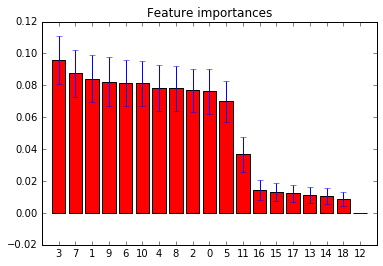

In [263]:
std = np.std([tree.feature_importances_ for tree in rf_red.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(red_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(red_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(red_X.shape[1]), indices)
plt.xlim([-1, red_X.shape[1]])
plt.show()

In [264]:
white_y = white['quality']

In [265]:
white_X = white.drop('quality', axis=1)

In [266]:
rf_white = RandomForestClassifier(n_estimators=100,random_state=0)
rf_white.fit(white_X, white_y)
importances = rf_white.feature_importances_

Feature ranking:
1. feature 3 (0.103174)
2. feature 6 (0.089605)
3. feature 7 (0.088087)
4. feature 8 (0.081738)
5. feature 1 (0.081143)
6. feature 4 (0.079858)
7. feature 5 (0.079852)
8. feature 9 (0.079490)
9. feature 2 (0.079037)
10. feature 10 (0.073732)
11. feature 0 (0.073462)
12. feature 11 (0.032649)
13. feature 14 (0.011641)
14. feature 13 (0.010847)
15. feature 16 (0.010550)
16. feature 15 (0.010503)
17. feature 17 (0.009269)
18. feature 12 (0.005362)


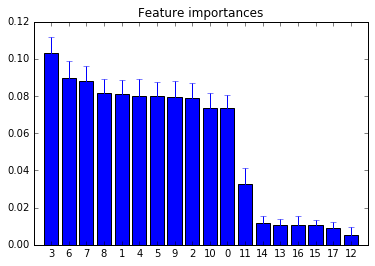

In [267]:
std = np.std([tree.feature_importances_ for tree in rf_white.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(white_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(white_X.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(white_X.shape[1]), indices)
plt.xlim([-1, white_X.shape[1]])
plt.show()

### Conclusion

In summary, for red wine the most important factors which contribute to whether red wine is good or not are: volatile acidity, residual sugar, and density

For white wine, the most important factors are: residual sugar, total sulfur dioxide and density

If given more time, I would perform deeper statistical analysis to further explore collinear variables, explore VIFs, and have do more EDA on individual features